In [1]:
import numpy as np
import wget
import os
import random

In [2]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()
#cuda = False;

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data as D

In [4]:
# Tutorail for torch version:
torch.__version__

'1.2.0'

In [5]:
data = ['house','tree', 'bicycle', 'dog', 'horse', 'car', 'clock', 'table','bus', 'laptop', 'mountain', 'pizza', 'sheep', 'shark']

for item in data:
    if not os.path.exists(item + '.npy'):
        url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/' +item +'.npy'
        wget.download(url)

In [6]:
all_data = []
for type in data:
     all_data.append(np.load(type + '.npy'))

In [7]:
start = 0
num_examples = 50000
image_df = np.zeros((num_examples ,784))
label_df = []

while start < num_examples :
    random_class = np.random.randint(0,len(data))
    random_index = np.random.randint(0,10000)
    image_df[start] = all_data[random_class][random_index,:]/255
    label_df.append(random_class)
    start += 1


In [8]:
image_df.shape

(50000, 784)

In [9]:
len(label_df)

50000

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

In [11]:
image_train, image_test, label_train, label_test = train_test_split(image_df, label_df, test_size=0.2, random_state=42)

In [12]:
print(len(image_train))
print(len(image_test))

40000
10000


In [13]:
class ObjectDS(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, image_df, label_df):
        self.image_df = image_df
        self.label_df = label_df
        self.len = len(image_df)
    
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset"""
        
        return (torch.tensor(image_df[index].reshape(1,28,28)).float(), label_df[index])

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len


In [14]:
class ObjectDS_Siam(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, image_df, label_df, train):
        """ Intialize the dataset
        """
        self.cuda = cuda
        self.image_df = image_df
        self.label_df = label_df
        self.len = len(image_df)
        self.train = train
        #Loop thru each image to get a pair
        self.test_data = []
        for i in range(self.len):
            random_image = np.random.randint(0,self.len)
            if(self.label_df[i] == self.label_df[random_image]):
                self.test_data.append([i,random_image,1])
            else:
                self.test_data.append([i,random_image,0])
    
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.train:
            target = np.random.randint(0, 2)
            if target == 1:
                #Return a pair of image that belong to same class
                same = False;
                while not same:
                    pic1 = np.random.randint(0, self.len)
                    pic2 = np.random.randint(0, self.len)
                    if(self.label_df[pic1]==self.label_df[pic2]):
                        same = True;
                img1 = torch.tensor(self.image_df[pic1]).reshape(1,28,28).float()
                img2 = torch.tensor(self.image_df[pic2]).reshape(1,28,28).float()
            else: 
                #return apair of image that does not belong to same class
                different = False;
                while not different:
                    pic1 = np.random.randint(0, self.len)
                    pic2 = np.random.randint(0, self.len)
                    if(self.label_df[pic1]!=self.label_df[pic2]):
                        different = True;
                img1 = torch.tensor(self.image_df[pic1]).reshape(1,28,28).float()
                img2 = torch.tensor(self.image_df[pic2]).reshape(1,28,28).float()
        else:
            #return fix pair of imags
            pic1  = self.test_data[index][0]
            img1 = torch.tensor(self.image_df[pic1]).reshape(1,28,28).float()
            pic2 = self.test_data[index][1]
            img2 = torch.tensor(self.image_df[pic2]).reshape(1,28,28).float()
            target = self.test_data[index][2]
        return (img1, img2), target
            
                
        #return (torch.tensor(image_df[index].reshape(1,28,28)).float(), label_df[index])

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len


In [15]:
train_dataset_base = ObjectDS(image_train, label_train)
test_dataset_base = ObjectDS(image_test, label_test)
train_dataset_siam = ObjectDS_Siam(image_train, label_train,True)
test_dataset_siam = ObjectDS_Siam(image_test, label_test,False)

In [16]:
# Set up data loaders
n_classes = len(data)
batch_size = 256
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
train_loader_base = torch.utils.data.DataLoader(train_dataset_base, batch_size=batch_size, shuffle=True, **kwargs)
test_loader_base = torch.utils.data.DataLoader(test_dataset_base, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
#from networks import EmbeddingNet, ClassificationNet
#from metrics import AccumulatedAccuracyMetric

#embedding_net = EmbeddingNet()
#model = ClassificationNet(embedding_net, n_classes=n_classes)
#if cuda:
 #   model.cuda()
#loss_fn = torch.nn.NLLLoss()
#lr = 1e-2
#optimizer = optim.Adam(model.parameters(), lr=lr)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
#n_epochs = 20
#log_interval = 50

In [17]:
#fit(train_loader_base, test_loader_base, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

In [18]:
batch_size = 128
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(train_dataset_siam, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(test_dataset_siam, batch_size=batch_size, shuffle=False, **kwargs)

In [19]:
# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [20]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

C:\Users\Admin\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/40000 (0%)]	Loss: 0.243974
Train: [12800/40000 (32%)]	Loss: 0.100064
Train: [25600/40000 (64%)]	Loss: 0.083960
Train: [38400/40000 (96%)]	Loss: 0.077519
Epoch: 1/20. Train set: Average loss: 0.0872
Epoch: 1/20. Validation set: Average loss: 0.0802
Train: [0/40000 (0%)]	Loss: 0.071018
Train: [12800/40000 (32%)]	Loss: 0.069705
Train: [25600/40000 (64%)]	Loss: 0.067152
Train: [38400/40000 (96%)]	Loss: 0.060960
Epoch: 2/20. Train set: Average loss: 0.0657
Epoch: 2/20. Validation set: Average loss: 0.0623
Train: [0/40000 (0%)]	Loss: 0.053433
Train: [12800/40000 (32%)]	Loss: 0.058428
Train: [25600/40000 (64%)]	Loss: 0.053858
Train: [38400/40000 (96%)]	Loss: 0.052533
Epoch: 3/20. Train set: Average loss: 0.0549
Epoch: 3/20. Validation set: Average loss: 0.0550
Train: [0/40000 (0%)]	Loss: 0.038802
Train: [12800/40000 (32%)]	Loss: 0.048026
Train: [25600/40000 (64%)]	Loss: 0.045819
Train: [38400/40000 (96%)]	Loss: 0.043177
Epoch: 4/20. Train set: Average loss: 0.0456
Epoch: 4/20. Valid

In [75]:
#mnist_classes = ['house','tree', 'bicycle', 'dog', 'horse', 'car', 'clock', 'table']
#colors = ['#d4fe80','#6bfde4','#4b4a48','#edb477','#edeeff',
   #       '#053b06','#a24936','#5f0f40','#efefd0','#ff8306',
  #        '#017f8d','#38293e','#100d11','#1d2124']

colors = ['#F2F3F4', '#222222', '#F3C300', '#875692', '#F38400', 
          '#A1CAF1', '#BE0032', '#C2B280', '#848482', '#008856', 
          '#E68FAC', '#0067A5', '#F99379', '#604E97', '#F6A600', 
          '#B3446C', '#DCD300', '#882D17', '#8DB600', '#654522', 
          '#E25822', '#2B3D26']




def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(20,20))
    for i in range(len(data)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.3, color=colors[i])
        plt.text(np.mean(embeddings[inds,0]), np.mean(embeddings[inds,1]), data[i])
        
                           
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(data)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            #print(model.get_embedding(images).data.cpu().numpy()[0])
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

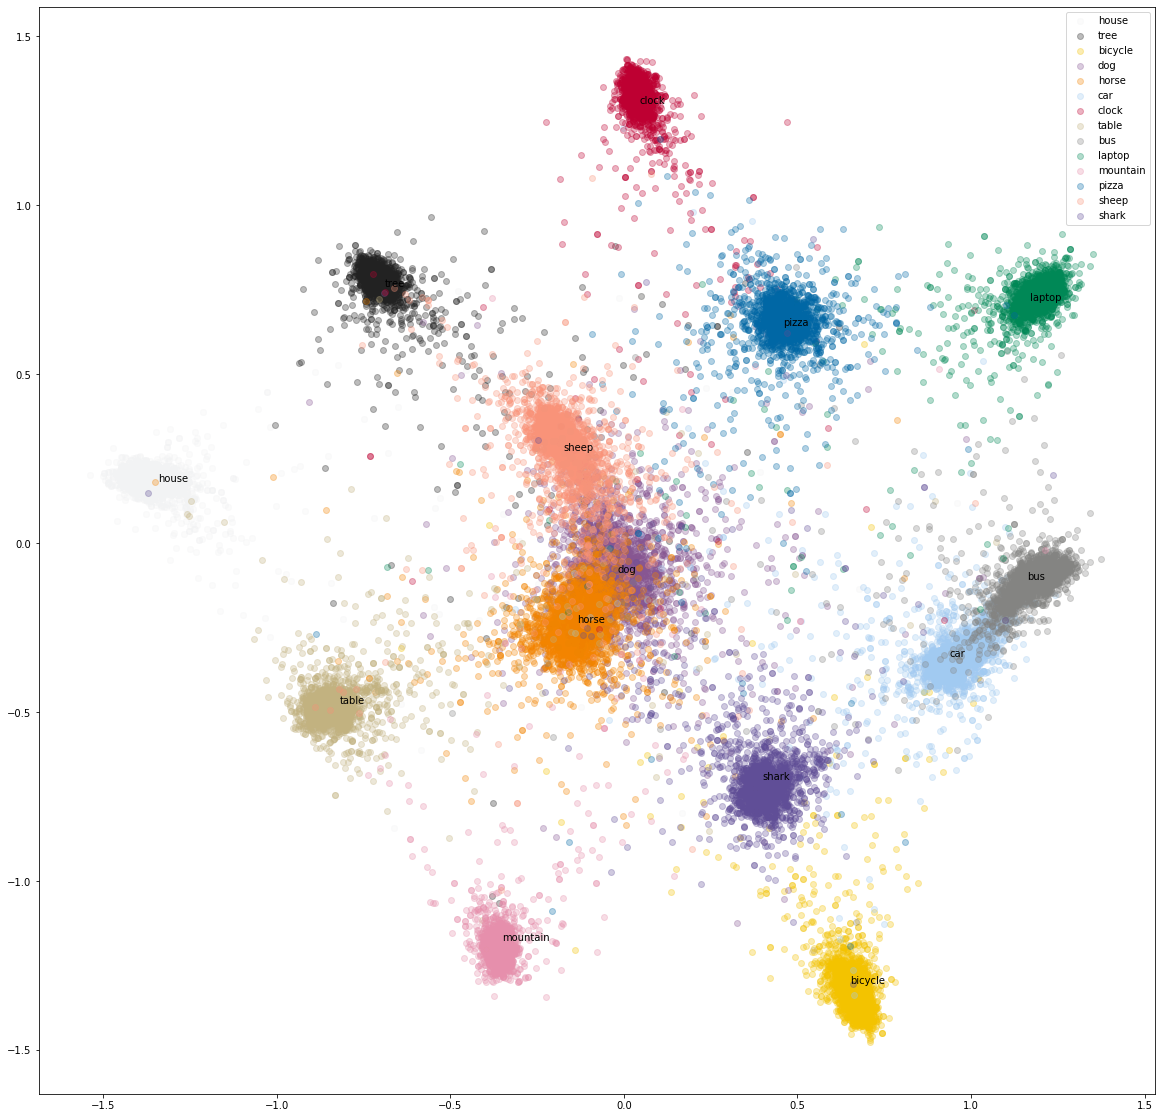

In [76]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader_base, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)


In [77]:
coordinates = [];
objects_embeddings = {}

def embeddings_get_info(embeddings, targets, xlim=None, ylim=None):
    for i in range(len(data)):
        inds = np.where(targets==i)[0]
        coordinates.append(np.mean(embeddings[inds,0])) #Append x coordinate
        coordinates.append(np.mean(embeddings[inds,1])) #Append y coordinate
        objects_embeddings[data[i]] = np.stack((embeddings[inds,0],embeddings[inds,1]), axis=-1)
        
        

In [78]:
embeddings_get_info(train_embeddings_cl, train_labels_cl)

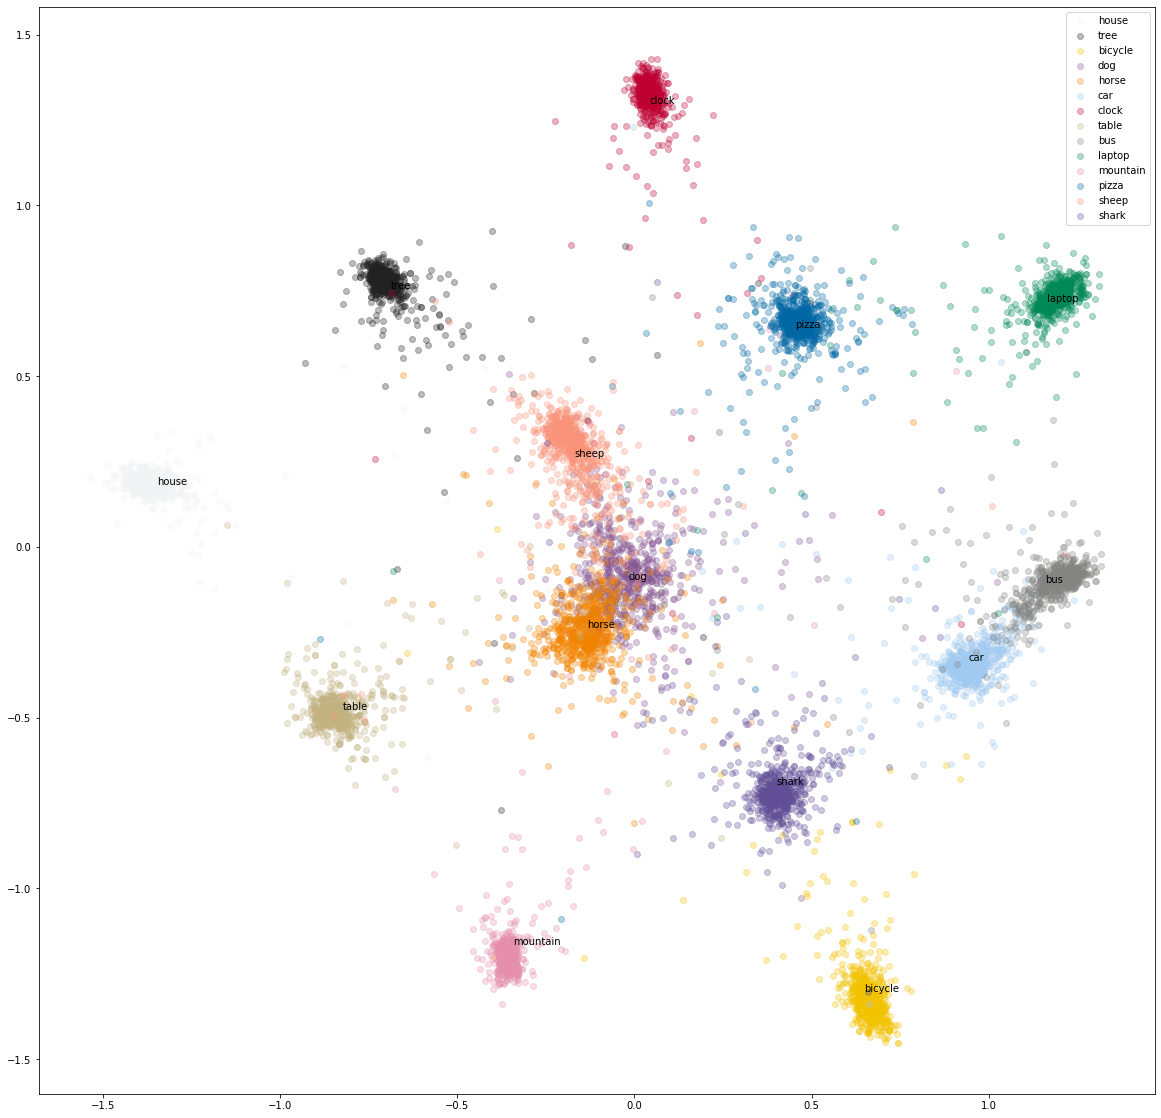

In [79]:
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader_base, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

In [80]:
from scipy.spatial import distance

In [81]:
pairwise_distance = {}

for first_object_ind in range(len(data)):
    for sec_object_ind in range(first_object_ind,len(data)):
        a = (coordinates[2*first_object_ind],coordinates[2*first_object_ind+1])
        #print(data[first_object_ind])
        b = (coordinates[2*sec_object_ind],coordinates[2*sec_object_ind+1])
        #print(data[sec_object_ind])
        #print(distance.euclidean(a, b))
        pairwise_distance[data[first_object_ind] +"-"+ data[sec_object_ind]] = distance.euclidean(a, b)
        
        

In [82]:
import operator

In [83]:
sorted_x = sorted(pairwise_distance.items(), key=operator.itemgetter(1))


In [159]:
from scipy import stats

In [205]:
intraclass_stats = []
for i in sorted_x[14:]:
    intraclass_stats.append(i[1])
print(np.percentile(intraclass_stats, 1))

0.3064838290566133


In [65]:
objects_embeddings['house']

array([[-1.31362426,  0.18219334],
       [-1.37139904,  0.1695416 ],
       [-1.378111  ,  0.18319884],
       ...,
       [-1.35354447,  0.18765342],
       [-1.35518038,  0.19273692],
       [-1.16438675, -0.00585143]])

In [111]:
>>> from scipy.cluster.hierarchy import average, fcluster
>>> from scipy.spatial.distance import pdist, squareform

In [66]:
 y = pdist(objects_embeddings['house'])

In [86]:
intra_class = []
for i in data:
    y = pdist(objects_embeddings[i])
    print(i, np.mean(y))
    intra_class.append(np.mean(y))

house 0.10646694187204436
tree 0.10602544779161076
bicycle 0.1147540643961215
dog 0.22126381396234512
horse 0.16194150058444787
car 0.14714029925093172
clock 0.0966010818426023
table 0.12915597305651827
bus 0.13213962187538278
laptop 0.11312719705323637
mountain 0.09730865732670275
pizza 0.12865629782784266
sheep 0.1697225345655312
shark 0.13837879448143187


In [99]:
val_embeddings_cl.shape

(10000, 2)

In [116]:
#Getting all pairs that have distance less than threshold
squareform(pdist(val_embeddings_cl)) < 0.22126381396234512

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ...,  True, False, False],
       [False, False,  True, ..., False,  True, False],
       ...,
       [False,  True, False, ...,  True, False, False],
       [False, False,  True, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [380]:
threshold_similar = 0.0966010818426023

In [381]:
x_object = np.where(squareform(pdist(val_embeddings_cl)) <= threshold_similar)[0]
y_object = np.where(squareform(pdist(val_embeddings_cl)) <= threshold_similar)[1]

In [382]:
pairs_of_object = np.stack((x_object,y_object), axis=-1)

In [383]:
count_true_positive = 0
for pair in pairs_of_object:
    #if val_labels_cl[pair[0]] == val_labels_cl[pair[1]] or (val_labels_cl[pair[0]] == 3 and val_labels_cl[pair[1]] == 4) or (val_labels_cl[pair[0]] == 4 and val_labels_cl[pair[1]] == 3):
    if val_labels_cl[pair[0]] == val_labels_cl[pair[1]]:
        count_true_positive += 1 #Increase if they are truly similar

In [384]:
print("Precision", count_true_positive/len(pairs_of_object))

Precision 0.9545932263669171


In [385]:
x_object = np.where(squareform(pdist(val_embeddings_cl)) > threshold_similar)[0]
y_object = np.where(squareform(pdist(val_embeddings_cl)) > threshold_similar)[1]
pairs_of_object_different = np.stack((x_object,y_object), axis=-1)


In [386]:
len(pairs_of_object_different)

95489924

In [269]:
from IPython import display

In [273]:
from tqdm import tqdm

In [ ]:
count_false_negative = 0
i_count = []
i =0
for pair in tqdm(pairs_of_object_different):
    #if val_labels_cl[pair[0]] == val_labels_cl[pair[1]] or (val_labels_cl[pair[0]] == 3 and val_labels_cl[pair[1]] == 4) or (val_labels_cl[pair[0]] == 4 and val_labels_cl[pair[1]] == 3):
    if val_labels_cl[pair[0]] == val_labels_cl[pair[1]]:
        count_false_negative += 1


 39%|█████████████████████████▍                                        | 36825598/95489924 [00:52<01:15, 778531.49it/s]

In [ ]:
count_false_negative

In [ ]:
print("Recall", count_true_positive/(count_true_positive+count_false_negative))

In [308]:
import cv2

In [366]:
start = 0
num_examples = 50000
image_df = np.zeros((num_examples ,784))
label_df = []

while start < num_examples :
    two_classes = np.random.choice(range(14), 2)
    temp1 = all_data[two_classes[0]]
    temp2 = all_data[two_classes[1]]
            
    img_generated = np.zeros((28,28)) #A big canvas
    
    random_index = np.random.randint(0,10000)
    pic_1 = temp1[random_index,:]/255

    random_index = np.random.randint(0,10000)
    pic_2 = temp2[random_index,:]/255
    pic_1 = cv2.resize(pic_1.reshape(28,28),(14,14))
    pic_2 = cv2.resize(pic_2.reshape(28,28),(14,14))
    random_chance = np.random.randint(0,2)
    if(random_chance == 0):
        img_generated[7:21,0:14] = pic_1.reshape(14,14)
        img_generated[7:21,14:28] = pic_2.reshape(14,14)
    else:
        img_generated[7:21,0:14] = pic_2.reshape(14,14)
        img_generated[7:21,14:28] = pic_1.reshape(14,14)
    image_df[start] = img_generated.reshape(1,784)
    label_df.append(str(two_classes[0])+str(two_classes[1]))
    start += 1
    

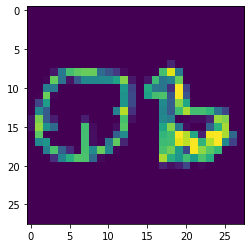

In [367]:
imshow(image_df[4].reshape(28,28))

In [369]:
len(label_df)

50000

In [327]:
class ObjectDS_Siam_Similarity(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, image_df, label_df, train):
        """ Intialize the dataset
        """
        self.cuda = cuda
        self.image_df = image_df
        self.label_df = label_df
        self.len = len(image_df)
        self.train = train
        #Loop thru each image to get a pair
        self.test_data = []
        for i in range(self.len):
            random_image = np.random.randint(0,self.len)
            if(self.label_df[i] == self.label_df[random_image]):
                self.test_data.append([i,random_image,1])
            else:
                self.test_data.append([i,random_image,0])
    
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.train:
            target = np.random.randint(0, 2)
            if target == 1:
                #Return a pair of image that belong to same class
                same = False;
                while not same:
                    pic1 = np.random.randint(0, self.len)
                    pic2 = np.random.randint(0, self.len)
                    if(self.label_df[pic1]==self.label_df[pic2]):
                        same = True;
                img1 = torch.tensor(self.image_df[pic1]).reshape(1,28,28).float()
                img2 = torch.tensor(self.image_df[pic2]).reshape(1,28,28).float()
            else: 
                #return apair of image that does not belong to same class
                different = False;
                while not different:
                    pic1 = np.random.randint(0, self.len)
                    pic2 = np.random.randint(0, self.len)
                    if(self.label_df[pic1]!=self.label_df[pic2]):
                        different = True;
                img1 = torch.tensor(self.image_df[pic1]).reshape(1,28,28).float()
                img2 = torch.tensor(self.image_df[pic2]).reshape(1,28,28).float()
        else:
            #return fix pair of imags
            pic1  = self.test_data[index][0]
            img1 = torch.tensor(self.image_df[pic1]).reshape(1,28,28).float()
            pic2 = self.test_data[index][1]
            img2 = torch.tensor(self.image_df[pic2]).reshape(1,28,28).float()
            target = self.test_data[index][2]
        return (img1, img2), target
            
                
        #return (torch.tensor(image_df[index].reshape(1,28,28)).float(), label_df[index])

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len
